# Optimizing the model
At this stage of the assignment, finding the optimal model architecture with necessary hyper-parameters is aimed. For easy testing, GPU utilization is performed.
## Necessary Imports
As the necessary imports, the model template implemented and the data utilities are imported. To fasten up the testing process, data compression into a **h5** file is implenented and used.

In [1]:
import tensorflow as tf
from data.data_utils import Dataset, save_dataset
import os
from model import AgeModel
import tensorflow.keras.losses as losses

print("Tensorflow version used: {}".format(tf.__version__))

Tensorflow version used: 2.3.0


## Hardware utilization
The utilization of the GPU effects the training time significantly for this assignment. To ensure that this implementation uses GPU, as an initial stage the presence of the GPU is checked. Even though it is not stated in the assignment that this utilization is not compulsory, it is performed for faster model evaluation.

In [2]:
from tensorflow.python.client import device_lib
def check_if_gpu_used():
    gpu_names = [x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    if len(gpu_names) >= 1:
        print("Number of GPUs used by Tensorflow: {}".format(len(gpu_names)))
    else:
        print("Tensorflow operates on CPU now.")
check_if_gpu_used()

Number of GPUs used by Tensorflow: 1


## Importing the dataset
The dataset given for the assignment is modeled with **Dataset** class. The importing process is as follows.

In [3]:
from time import time
data_path = os.path.join(os.getcwd(), 'data')
dataset_path = os.path.join(data_path, 'UTKFace_downsampled')
train_path = os.path.join(dataset_path, 'training_set')
val_path = os.path.join(dataset_path, 'validation_set')
test_path = os.path.join(dataset_path, 'test_set')
start = time()
dataset = Dataset(train_path, val_path, test_path, 'jpg')
end = time()
# Monitor dataset details
## Training set
print("Training data shape: {}".format(dataset.train_data[0].shape))
print("Training labels shape: {}".format(dataset.train_data[1].shape))
## Validation set
print("Validation data shape: {}".format(dataset.val_data[0].shape))
print("Validation labels shape: {}".format(dataset.val_data[1].shape))
## Test set
print("Testing data shape: {}".format(dataset.test_data[0].shape))
print("Testing labels shape: {}".format(dataset.test_data[1].shape))
print("Time to construct dataset with direct file I/O: {:.3f} seconds".format(end - start))

INFO: Dataset constructed
Training data shape: (5400, 91, 91, 1)
Training labels shape: (5400,)
Validation data shape: (2315, 91, 91, 1)
Validation labels shape: (2315,)
Testing data shape: (1159, 91, 91, 1)
Testing labels shape: (1159,)
Time to construct dataset with direct file I/O: 3.517 seconds


## Dataset compression
To achieve efficient access to the dataset, the simultaneous file I/O is attmpted to be minimized. In order to do that an hierarchical data model HDF5 is used, which is a binary data format. The data access and data compression process is given as follows.

In [4]:
import h5py
import numpy as np
datafile_path = os.path.join(data_path, "dataset.h5")
#save_dataset(data_path, dataset) # Compressing data in h5 format
start = time()
f = h5py.File(datafile_path, "r")
train_samples = np.array(f["train_samples"])
train_labels = np.array(f["train_labels"])
val_samples = np.array(f["val_samples"])
val_labels = np.array(f["val_labels"])
test_samples = np.array(f["test_samples"])
test_labels = np.array(f["test_labels"])
end = time()
f.close()
print("Monitoring compressed data details")
## Training set
print("Training data shape: {}".format(train_samples.shape))
print("Training labels shape: {}".format(train_labels.shape))
## Validation set
print("Validation data shape: {}".format(val_samples.shape))
print("Validation labels shape: {}".format(val_labels.shape))
## Test set
print("Testing data shape: {}".format(test_samples.shape))
print("Testing labels shape: {}".format(test_labels.shape))
print("Time to construct the dataset from compressed file: {:.3f} seconds".format(end - start))

Monitoring compressed data details
Training data shape: (5400, 91, 91, 1)
Training labels shape: (5400,)
Validation data shape: (2315, 91, 91, 1)
Validation labels shape: (2315,)
Testing data shape: (1159, 91, 91, 1)
Testing labels shape: (1159,)
Time to construct the dataset from compressed file: 0.165 seconds


Is training image 0 equal in both: True
Is validation image 0 equal in both: True
Is testing image 0 equal in both: True


Text(0.5, 1.0, 'Testing Image 0 from file I/O')

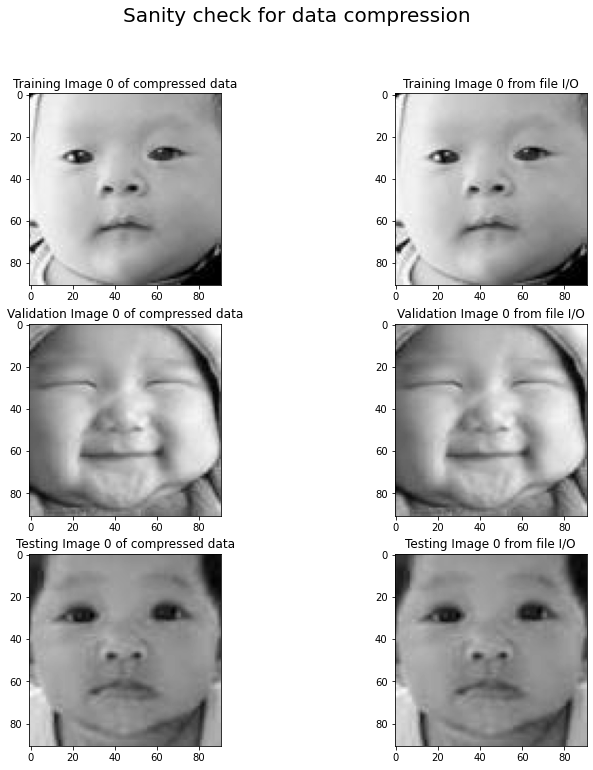

In [5]:
# Sanity check to ensure that the images imported are the same
print("Is training image 0 equal in both: {}".format(np.array_equal(train_samples[0], dataset.train_data[0][0])))
print("Is validation image 0 equal in both: {}".format(np.array_equal(val_samples[0], dataset.val_data[0][0])))
print("Is testing image 0 equal in both: {}".format(np.array_equal(test_samples[0], dataset.test_data[0][0])))
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle("Sanity check for data compression", fontsize=20)
axes[0,0].imshow(train_samples[0], cmap="gray")
axes[0,0].set_title("Training Image 0 of compressed data")
axes[0,1].imshow(dataset.train_data[0][0], cmap="gray")
axes[0,1].set_title("Training Image 0 from file I/O")
axes[1,0].imshow(val_samples[0], cmap="gray")
axes[1,0].set_title("Validation Image 0 of compressed data")
axes[1,1].imshow(dataset.val_data[0][0], cmap="gray")
axes[1,1].set_title("Validation Image 0 from file I/O")
axes[2,0].imshow(test_samples[0], cmap="gray")
axes[2,0].set_title("Testing Image 0 of compressed data")
axes[2,1].imshow(dataset.test_data[0][0], cmap="gray")
axes[2,1].set_title("Testing Image 0 from file I/O")

## Initial non-regularized model and checking the power of it
For our initial model, we benefited from the architecture proposed for VGG-16 and formed a similar model to it. To see whether it is powerful enough, we trained it on a small amount of data. In this task, we specified the amount of data as 20 samples.

In [6]:
# Generate random data indexes
random_idx = np.random.permutation(train_samples.shape[0])
random_train_sammples = train_samples[random_idx[:20]]
random_train_labels = train_labels[random_idx[:20]]

In [29]:
# Model specification
non_regularized_model = []
non_regularized_model.append({"type": "conv2d", "filters": 32, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None})
non_regularized_model.append({"type": "conv2d", "filters": 32, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None})
non_regularized_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
non_regularized_model.append({"type": "conv2d", "filters": 64, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None})
non_regularized_model.append({"type": "conv2d", "filters": 64, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None})
non_regularized_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None})
non_regularized_model.append({"type": "pool", "pool_type": "max", "pool_size": (2,2), "strides": None, "padding": "valid"})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None})
non_regularized_model.append({"type": "conv2d", "filters": 128, "kernel_size": (3,3), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None})
non_regularized_model.append({"type": "conv2d", "filters": 256, "kernel_size": (1,1), "strides":(1,1), "padding":"valid", "activation": "relu", "initializer": "xavier", "regularizer": None})
non_regularized_model.append({"type": "flatten"})
non_regularized_model.append({"type": "dense", "units": 256, "activation": "relu", "initializer": "xavier", "regularizer": None})
non_regularized_model.append({"type": "dense", "units": 128, "activation": "relu", "initializer": "xavier", "regularizer": None})
non_regularized_model.append({"type": "dense", "units": 64, "activation": "relu", "initializer": "xavier", "regularizer": None})
non_regularized_model.append({"type": "dense", "units": 1, "activation": "relu", "initializer": "xavier", "regularizer": None})

In [30]:
# Building the model
model_to_overfit = AgeModel(non_regularized_model, "channels_last")
model_to_overfit.build_comp_graph((None, 91, 91, 1)) # Building computational graph to monitor dimensions of layer matrices
model_to_overfit.summary()

INFO: Model constructed
Model: "age_model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 89, 89, 32)        320       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 41, 41, 64)        18496     
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 39, 39, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 19, 19, 64)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (N

Loss for the non-regularized model after 2000 epochs: 0.2318611890077591
Minimum loss value achieved: 0.075997494161129


Text(0.5, 1.0, 'Loss plot for the non-regularized model')

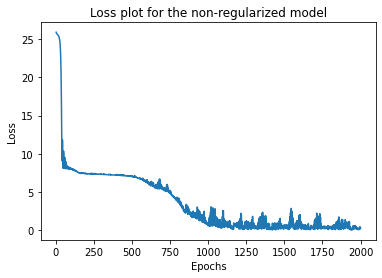

In [31]:
# Compile and run the model
optim = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.MeanAbsoluteError()
model_to_overfit.compile(loss=loss, optimizer=optim)
history = model_to_overfit.fit(x=random_train_sammples, y=random_train_labels, epochs=2000, verbose=0)
losses = history.history["loss"]
print("Loss for the non-regularized model after 2000 epochs: {}".format(losses[-1]))
print("Minimum loss value achieved: {}".format(np.amin(losses)))
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss plot for the non-regularized model")

## Searching for optimal learning rate and regularization
Given the model for testing whteher the model complexity is enough, a coarse search is performed to find the optimal regularization and learning rate values.